### Extract variables covering the region around the WREF site.
Input: ERA5: 2001 - 2020 hourly

In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from yllib.plot import plot_map
import cartopy.crs as ccrs

%matplotlib inline
%config InlineBackend.figure_format='retina'
mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'  

In [3]:
rootdir = '/global/cfs/projectdirs/m1657/liuy351/TallTower/Weather_pattern'
ear5_root = '/pscratch/sd/y/yeliu/MetOcean'
topo_domain = [-127, -116, 41, 50]
data_domain = [-124, -119, 43, 48]
WREF_location = [-121.9519, 45.8205]
domain_era5_dict = {'longitude':slice(topo_domain[0]+360, topo_domain[1]+360), 'latitude':slice(topo_domain[3], topo_domain[2])}

In [4]:
topo = xr.open_dataset(f'../ERA5_reduced/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc')['Z'].squeeze() / 9.8
topo = topo.sel(**domain_era5_dict)
# topo.plot()

(0.5, 0.5)


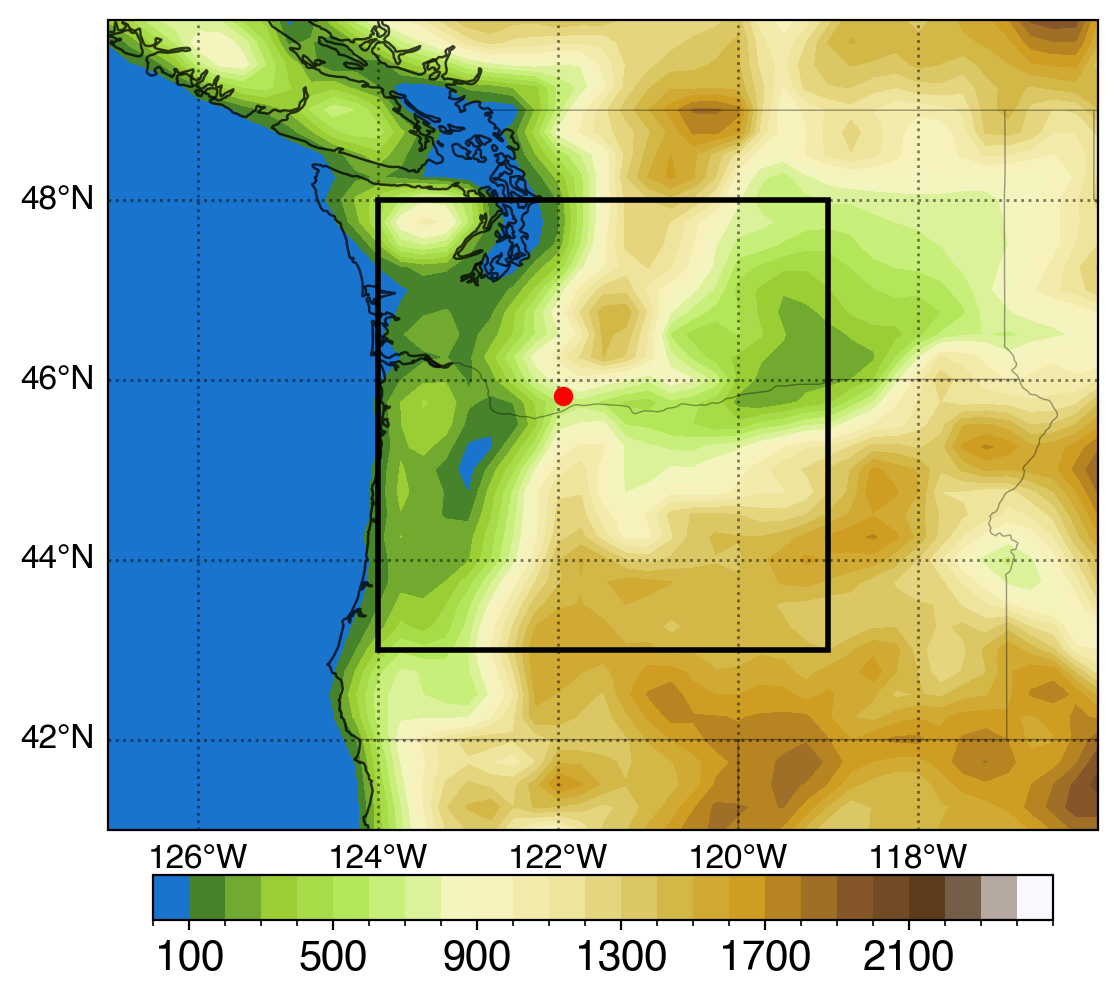

In [5]:
from func_plot_on_map import plot_on_map
projection = ccrs.PlateCarree()

fig, axs = plt.subplots(
    1, 1, figsize=(14, 5), 
    subplot_kw={'projection': projection}
)
# axs = axs.ravel()
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.95, hspace=0.03, wspace=0.05)

abcd=list('abcdefghijk')
lat = topo.latitude
lon = topo.longitude
#----------------------------------
ax = axs
cs, clev = plot_on_map(
    topo,
    fig=fig, ax=ax, extent=topo_domain,
    clev=[-100]+list(np.linspace(100,2400,24))+[10000],
    draw_colorbar=False,
    lat=lat, lon=lon,
    draw_ylabel=True, 
    cmap='OceanLakeLandSnow',
    # title=f'(a) Control',
    title_kwargs=dict(fontsize=16),
)

plot_map.add_rectangle(ax, data_domain, ec='k')
plot_map.add_geolocation(ax, WREF_location)
_=plot_map.add_colorbar(cs, axs, clev[1:-1:4], pad=0.05, shrink=0.8, aspect=20)

### Load extracted data and calculate the anomaly

In [6]:
era5_reduced_root = '../ERA5_reduced'
var_list = ['t500', 'z500', 't850', 'z850','sp','2t']
climate_period = ('2001-01-01 00:00','2024-12-31 23:00')
climate_years = pd.to_datetime(climate_period).year
climate_years

Index([2001, 2024], dtype='int32')

In [7]:
def calc_anomaly(ds):
    return (
        ds.mean('time'),
        ds.mean(['time', 'latitude', 'longitude']),
        ds.max('time'),
        ds.max(['time', 'latitude', 'longitude']),
        ds.min('time'),
        ds.min(['time', 'latitude', 'longitude'])
    )

def remove_monthly_cycle(ds):
    return ds - ds.rolling(time=30, min_periods=2, center=True).mean() 


In [8]:
f'{era5_reduced_root}/{var}.*.daymean.nc'

'../ERA5_reduced/100u.*.daymean.nc'

In [9]:
# for var in ['t500', 'z500', 't850', 'z850','sp','2t']:
#     ds = xr.open_dataset(f'{era5_reduced_root}/{var}.{climate_years[0]}-{climate_years[1]}.daymean.nc').sel(time=slice(*climate_period)).squeeze()
#     ds.to_netcdf(f'{era5_reduced_root}/{var}.{climate_years[0]}-{climate_years[1]}.daymean.anomaly.nc')
for var in ['100u', '100v']:
    ds = xr.open_dataset(f'{era5_reduced_root}/{var}.{climate_years[0]}-{climate_years[1]}.daymean.nc').sel(time=slice(*climate_period)).squeeze()
    ds.to_netcdf(f'{era5_reduced_root}/{var}.{climate_years[0]}-{climate_years[1]}.daymean.anomaly.nc')

In [9]:
for var in ['t500', 'z500', 't850', 'z850','sp','2t']:
    print(f'{era5_reduced_root}/{var}/*/*.daymean.nc')
    ds = xr.open_mfdataset(f'{era5_reduced_root}/{var}/*/*.daymean.nc').sel(time=slice(*climate_period)).squeeze()
    ds.to_netcdf(f'{era5_reduced_root}/{var}.{climate_years[0]}-{climate_years[1]}.daymean.anomaly.nc')
    # ano = ds - ds.rolling(time=30*24, min_periods=2, center=True).mean()
    # ano.to_netcdf(f'{era5_reduced_root}/{var}.{climate_years[0]}-{climate_years[1]}.anomaly.nc')
    # ds_mean2d, ds_mean1d, ds_max2d, ds_max1d, ds_min2d, ds_min1d = calc_anomaly(ds)
    # print(ds)

../ERA5_reduced/t500/*/*.daymean.nc


OSError: no files to open

In [21]:
for var in ['sp', '2t']:
    ds = xr.open_mfdataset(f'{era5_reduced_root}/sfc/*/*_{var}.*.nc', combine='nested', concat_dim='time').sel(time=slice(*climate_period)).squeeze()
    ds.to_netcdf(f'{era5_reduced_root}/{var}.{climate_years[0]}-{climate_years[1]}.nc')
    ano = ds - ds.rolling(time=30*24, min_periods=2, center=True).mean()
    ano.to_netcdf(f'{era5_reduced_root}/{var}.{climate_years[0]}-{climate_years[1]}.anomaly.nc')

In [152]:
ds_mean2d, ds_mean1d, ds_max2d, ds_max1d, ds_min2d, ds_min1d = calc_anomaly(ds)

In [12]:
f'{era5_reduced_root}/sfc/*/*_{var}.*.nc'

'./ERA5_reduced/sfc/*/*_2t.nc'